# Example workflow
In this tutorial we present the main functionality of our python package. The data set we will use is derived from REDIportal (http://srv00.recas.ba.infn.it/atlas/), a collection of human RNA A-to-I editing locations and we are going to classify whether an editing location is located in an ALU repeat region, in another repetitive region (non-alu) or in a non-repetitive region. Thus, this is a 3-class single-label classification task. This data set is easy to classify, because repetitve regions tend to have strong sequence-structure motifs. In any case, the purpose of this tutorial is not a particular biological interpretation, but to showcase the main output of the neural network.

Let's start by doing some imports and by setting up an output folder that will contain all output files in the end (you can find the folder in the github repo).

In [1]:
import os
from IPython.display import Image
from pysster.Data import Data
from pysster.Grid_Search import Grid_Search
from pysster import utils

output_folder = "example_editing/"
if not os.path.isdir(output_folder):
    os.makedirs(output_folder)

Using TensorFlow backend.


The data set consists of sequences of length 301 centered at an editing site, that is, all sequences in all classes have an A at position 151. For every class we randomly sampled 50000 editing sites. We also predicted the secondary structures for all sequences. The input for the network are fasta files containing the RNA sequences and corresponding secondary structures. A single entry looks conceptually like this:
```
> header
CCCCAUAGGGG
((((...)))) (-3.3)
SSSSHHHSSSS
```
The second line shows the secondary structure as a dot-bracket string, the third line shows the same structure as an annotated structure string. The third line is based on a 4-letter alphabet: "H" means hairpin, "I" internal loop, "M" multi loop and "S" means stem. Our package provides functions to predict secondary structures and to annotate existing dot-bracket strings to produce the needed fasta format, have a look at the utils API documentation. We have already prepared three fasta files, one per class, and can now directly load these into a Data object. We also have to provide the alphabet of our sequences (using ("ACGU", "().") would train the network on the dot-bracket strings later on):

In [2]:
data = Data(["data/alu.fa.gz", "data/rep.fa.gz", "data/nonrep.fa.gz"], ("ACGU", "HIMS"))
print(data.get_summary())

              class_0    class_1    class_2
all data:       50000      50000      50000
training:       34962      35067      34971
validation:      7539       7477       7484
test:            7499       7456       7545


Loading the data will also automatically compute a random 70%/15%/15% training/validation/test split. If you want to change these ratios or if you want to provide a seed for the random number generator to get reproducible splits you can do so:

In [3]:
data.train_val_test_split(portion_train=0.6, portion_val=0.2, seed=3)
print(data.get_summary())

              class_0    class_1    class_2
all data:       50000      50000      50000
training:       30035      29925      30040
validation:      9995      10125       9880
test:            9970       9950      10080


We are now ready to train a model using the data. We will run a small hyperparameter grid search training 4 different models. We define lists of potential parameter values and the Grid_Search object will train all models on the training data and return the single model with the highest ROC-AUC on the validation data. In this case we will try models with either 2 or 3 convolutional layers and with an input dropout rate of either 0.1 or 0.4. All convolutional layers will have 20 kernels, each of length 20. Parameters that are not defined in the "params" variable will have default values (look at the Model object API documentation for a list of all possible parameters).

if you don't want to do a grid search you can also directly train a single model:
```
params = {"conv_num": 2, "kernel_num": 20}
model = Model(params, data)
model.train(data)
```

However, for the tutorial we will run the grid search:

In [4]:
params = {"conv_num": [2, 3], "kernel_num": [20], "kernel_len": [20], "dropout_input": [0.1, 0.4]}
searcher = Grid_Search(params)
model, summary = searcher.train(data, verbose=False)

The grid search training also returns a summary string with the ROC-AUC of all models:

In [5]:
print(summary)

# kernel_num: [20]
# conv_num: [2, 3]
# kernel_len: [20]
# dropout_input: [0.1, 0.4]
kernel_num conv_num kernel_len dropout_input roc-auc
        20        2         20           0.1 0.95862
        20        3         20           0.1 0.95568
        20        3         20           0.4 0.94633
        20        2         20           0.4 0.94374



We can now perform the final evaluation of our model on the test data. Calling the predict functions returns an array of shape (number of sequences, number of classes) holding predicted probabilites (instead of passing "test" to the function you can also pass "train", "val" or "all").

In [6]:
predictions = model.predict(data, "test")
predictions

array([[  7.31742680e-01,   2.66776741e-01,   1.48058450e-03],
       [  3.83570932e-06,   1.65412650e-01,   8.34583580e-01],
       [  7.24110009e-07,   2.17644349e-01,   7.82354891e-01],
       ..., 
       [  1.00000000e+00,   2.21675100e-09,   4.20700950e-08],
       [  2.29922712e-08,   9.99985099e-01,   1.49504813e-05],
       [  2.86674606e-07,   2.21208975e-01,   7.78790772e-01]], dtype=float32)

We also need the true labels and we can get them from the data object. The result is again an array of shape (number of sequences, number of classes).

In [7]:
labels = data.get_labels("test")
labels

array([[1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       ..., 
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=uint32)

Given predictions and labels we can now create ROC and precision-recall curve plots and get an overview of a number of performance metrics. In a multi-class setting metrics are computed in 1 vs. all approach, as they are only really defined for binary classifications. Average values are weighted by the number sequences 'n' in each class.

In [8]:
utils.plot_roc(labels, predictions, output_folder+"roc.png")
utils.plot_prec_recall(labels, predictions, output_folder+"prec.png")
print(utils.get_performance_report(labels, predictions))

             precision    recall  f1-score   roc-auc    pr-auc          n
     class_0     0.972     0.968     0.970     0.998     0.996  |    9970
     class_1     0.911     0.661     0.766     0.934     0.897  |    9950
     class_2     0.751     0.957     0.842     0.946     0.862  |   10080


weighted avg     0.878     0.863     0.859     0.959     0.918  |   30000




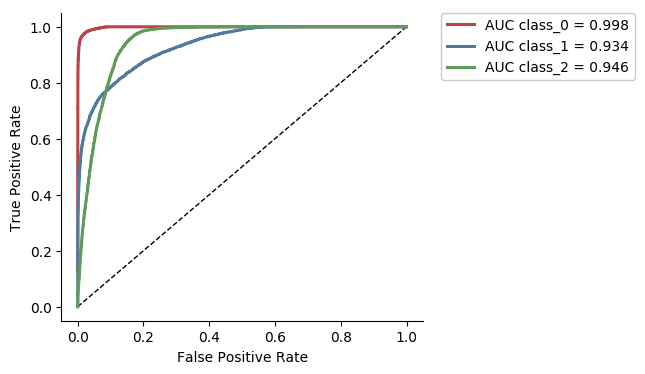

In [9]:
Image(output_folder+"roc.png")

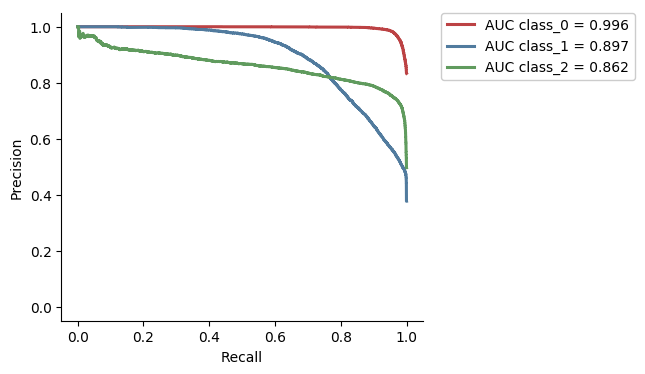

In [10]:
Image(output_folder+"prec.png")

We will now visualize what motifs the kernels of the first convolutional layer have learned and where these motifs are located in our sequences.

The visualizations are based on our held-out test data. First, we need the output of the first convolutional layer given the test sequences. This output is called 'activations'. You can think of a kernel as a position-weight matrix (PWM) and activations are the result of sliding with the kernel over our input sequence, one position at a time. The result is a vector of numbers and the position of the maximum activation shows to which subsequence the kernel is most similar. If the maximum activation is above a certain threshold we can extract the corresponding subsequence of the length of the kernel from the input. If we do this for all input sequences we get a number of subsequences, all of the same length, and we can compute a PWM. In addition, plotting the position of the maximum activation (e.g. as a histogram) shows exactly where our motifs are located. Doing all of this separately for every class even gives a class enrichment for our motifs!

Let's visualize all of our 20 kernels by calling the visualize_kernel function. The function creates 3 output images for every kernel and it also returns Motif objects holding the PWM and an importance score of the kernel (higher == better). The importance score is a rough estimate. There is no consensus on how to compute feature importance for neural networks. In our case the score of a kernel is computed as maximum of the average maximum activations per class minus minimum of the average maximum activations per class (there will be a plot later on to show this). The idea is that kernels that show big differences across classes (i.e. kernels that are strongly enriched in one class and little to none in other classes) are more important for the network to deliver correct predictions. A high score (or a low score) does not mean, that the motif is not biologically meaningful, sometimes motifs might be similarly enriched in multiple classes and therefore not be that important for the classification task. You should always look at all your motifs by eye. The score only gives a rough guide on where to start.

In [11]:
activations = model.get_max_activations(data, "test")
logos = []
for kernel in range(model.params["kernel_num"]):
    logo, score = model.visualize_kernel(activations, data, kernel, output_folder)
    logos.append(logo)
    print("kernel {}:\t{}".format(kernel, score))

kernel 0:	0.1687600314617157
kernel 1:	0.062167465686798096
kernel 2:	0.06771072745323181
kernel 3:	0.11587005853652954
kernel 4:	0.06960389018058777
kernel 5:	0.23484182357788086
kernel 6:	0.04697442054748535
kernel 7:	0.08932191133499146
kernel 8:	0.04531437158584595
kernel 9:	0.027829617261886597
kernel 10:	0.25985458493232727
kernel 11:	0.23003831505775452
kernel 12:	0.2236877977848053
kernel 13:	0.1695898175239563
kernel 14:	0.051149725914001465
kernel 15:	0.19758236408233643
kernel 16:	0.20705890655517578
kernel 17:	0.31577029824256897
kernel 18:	0.07095670700073242
kernel 19:	0.18762215971946716


As said, the function creates three plots for every kernel. We've looked at all plots and decided to have a closer look at kernel 13. Here is the sequence-structure motif:

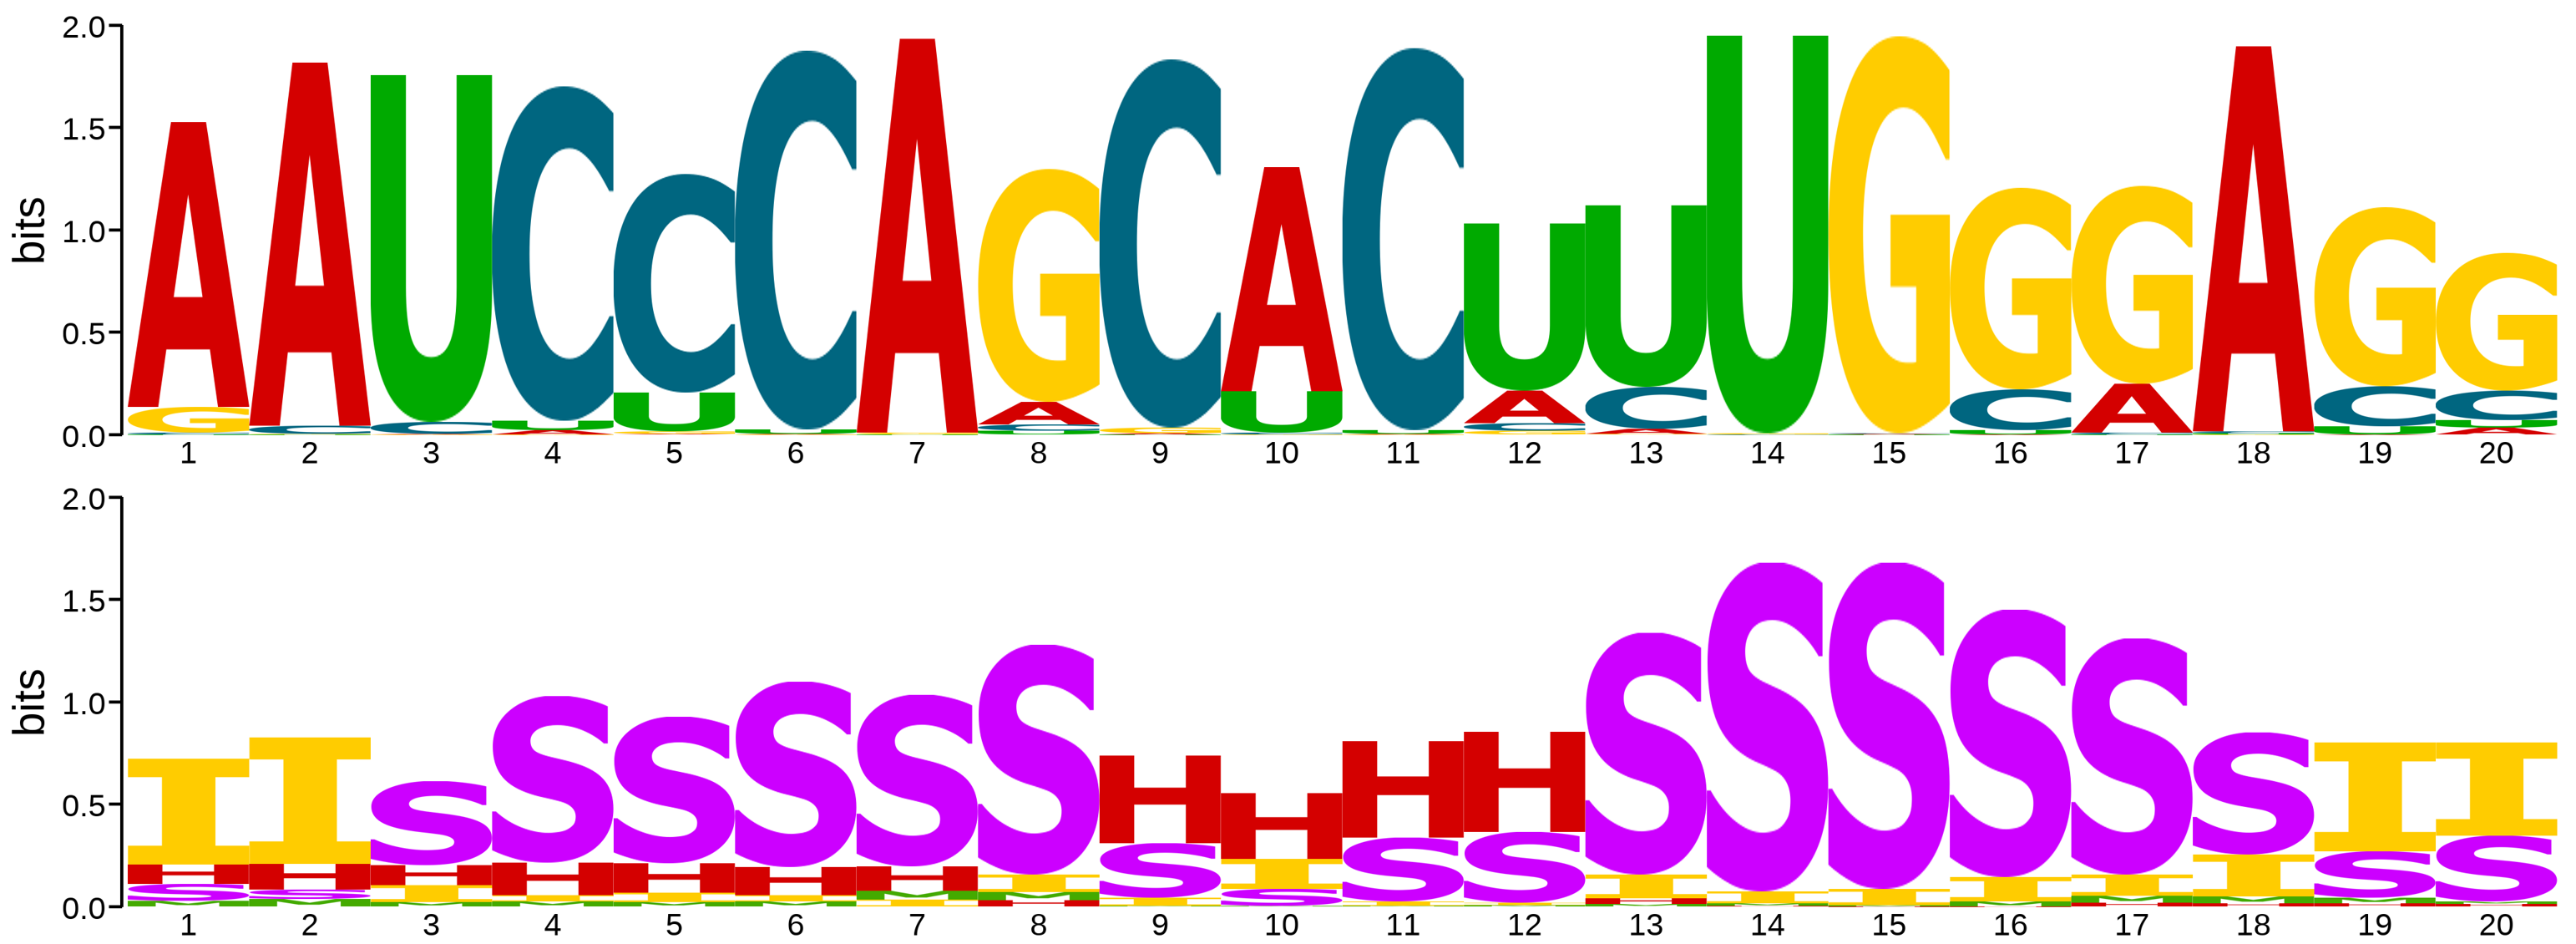

In [29]:
Image(output_folder+"motif_kernel_13.png")

The next plot shows the class-wise distribution of the maximum activations. The score mentioned earlier can be seen here, it is the average max activation of class_0 minus the average max activation of class_2 (=0.1696). Looking at the plot shows,  that this kernel is enriched in class_0, the ALU repeat class.

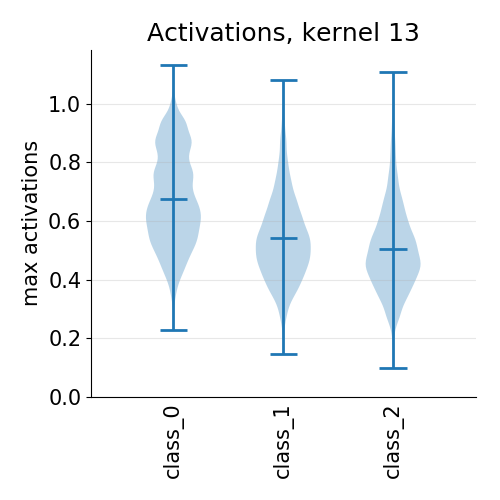

In [30]:
Image(output_folder+"activations_kernel_13.png")

The last plot shows the positional enrichment of the kernel, that is, the position of the maximum activations as talked about earlier (the histograms). The other plots show the mean activations for all sequence position. Both plots are only based on sequences that led to a maximum activation higher than a certain threshold. Histogram and mean activation plot are usually identical, but in case the histogram is very sparse the mean activation plot might be easier to look at.

In this case, we only have a strong signal for the ALU class and if we have a closer look we can see that the motif has its strongest enrichment at position 150 and 151. As mentioned at the very beginning the editing position is always at position 151, indicating that the two A's at the beginning of our motif might be often edited.

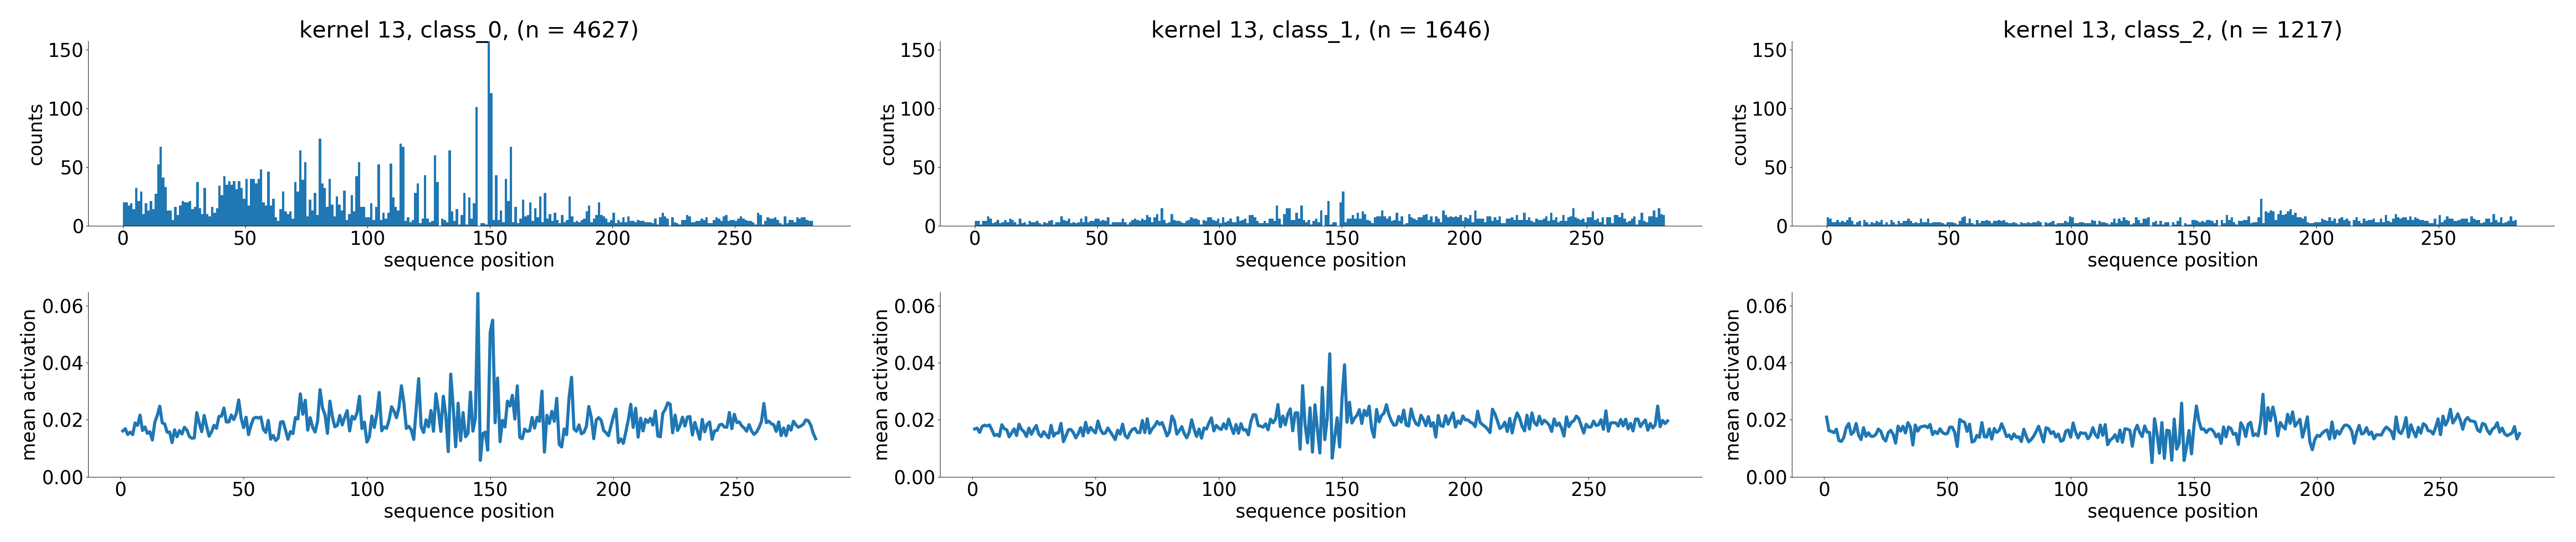

In [32]:
Image(output_folder+"position_kernel_13.png")

ALU repeats tend to form a specific secondary structure, and in fact, comparing our motif with the ALU structure shows a perfect match for both sequence and structure motif starting at position 27 in the following image:

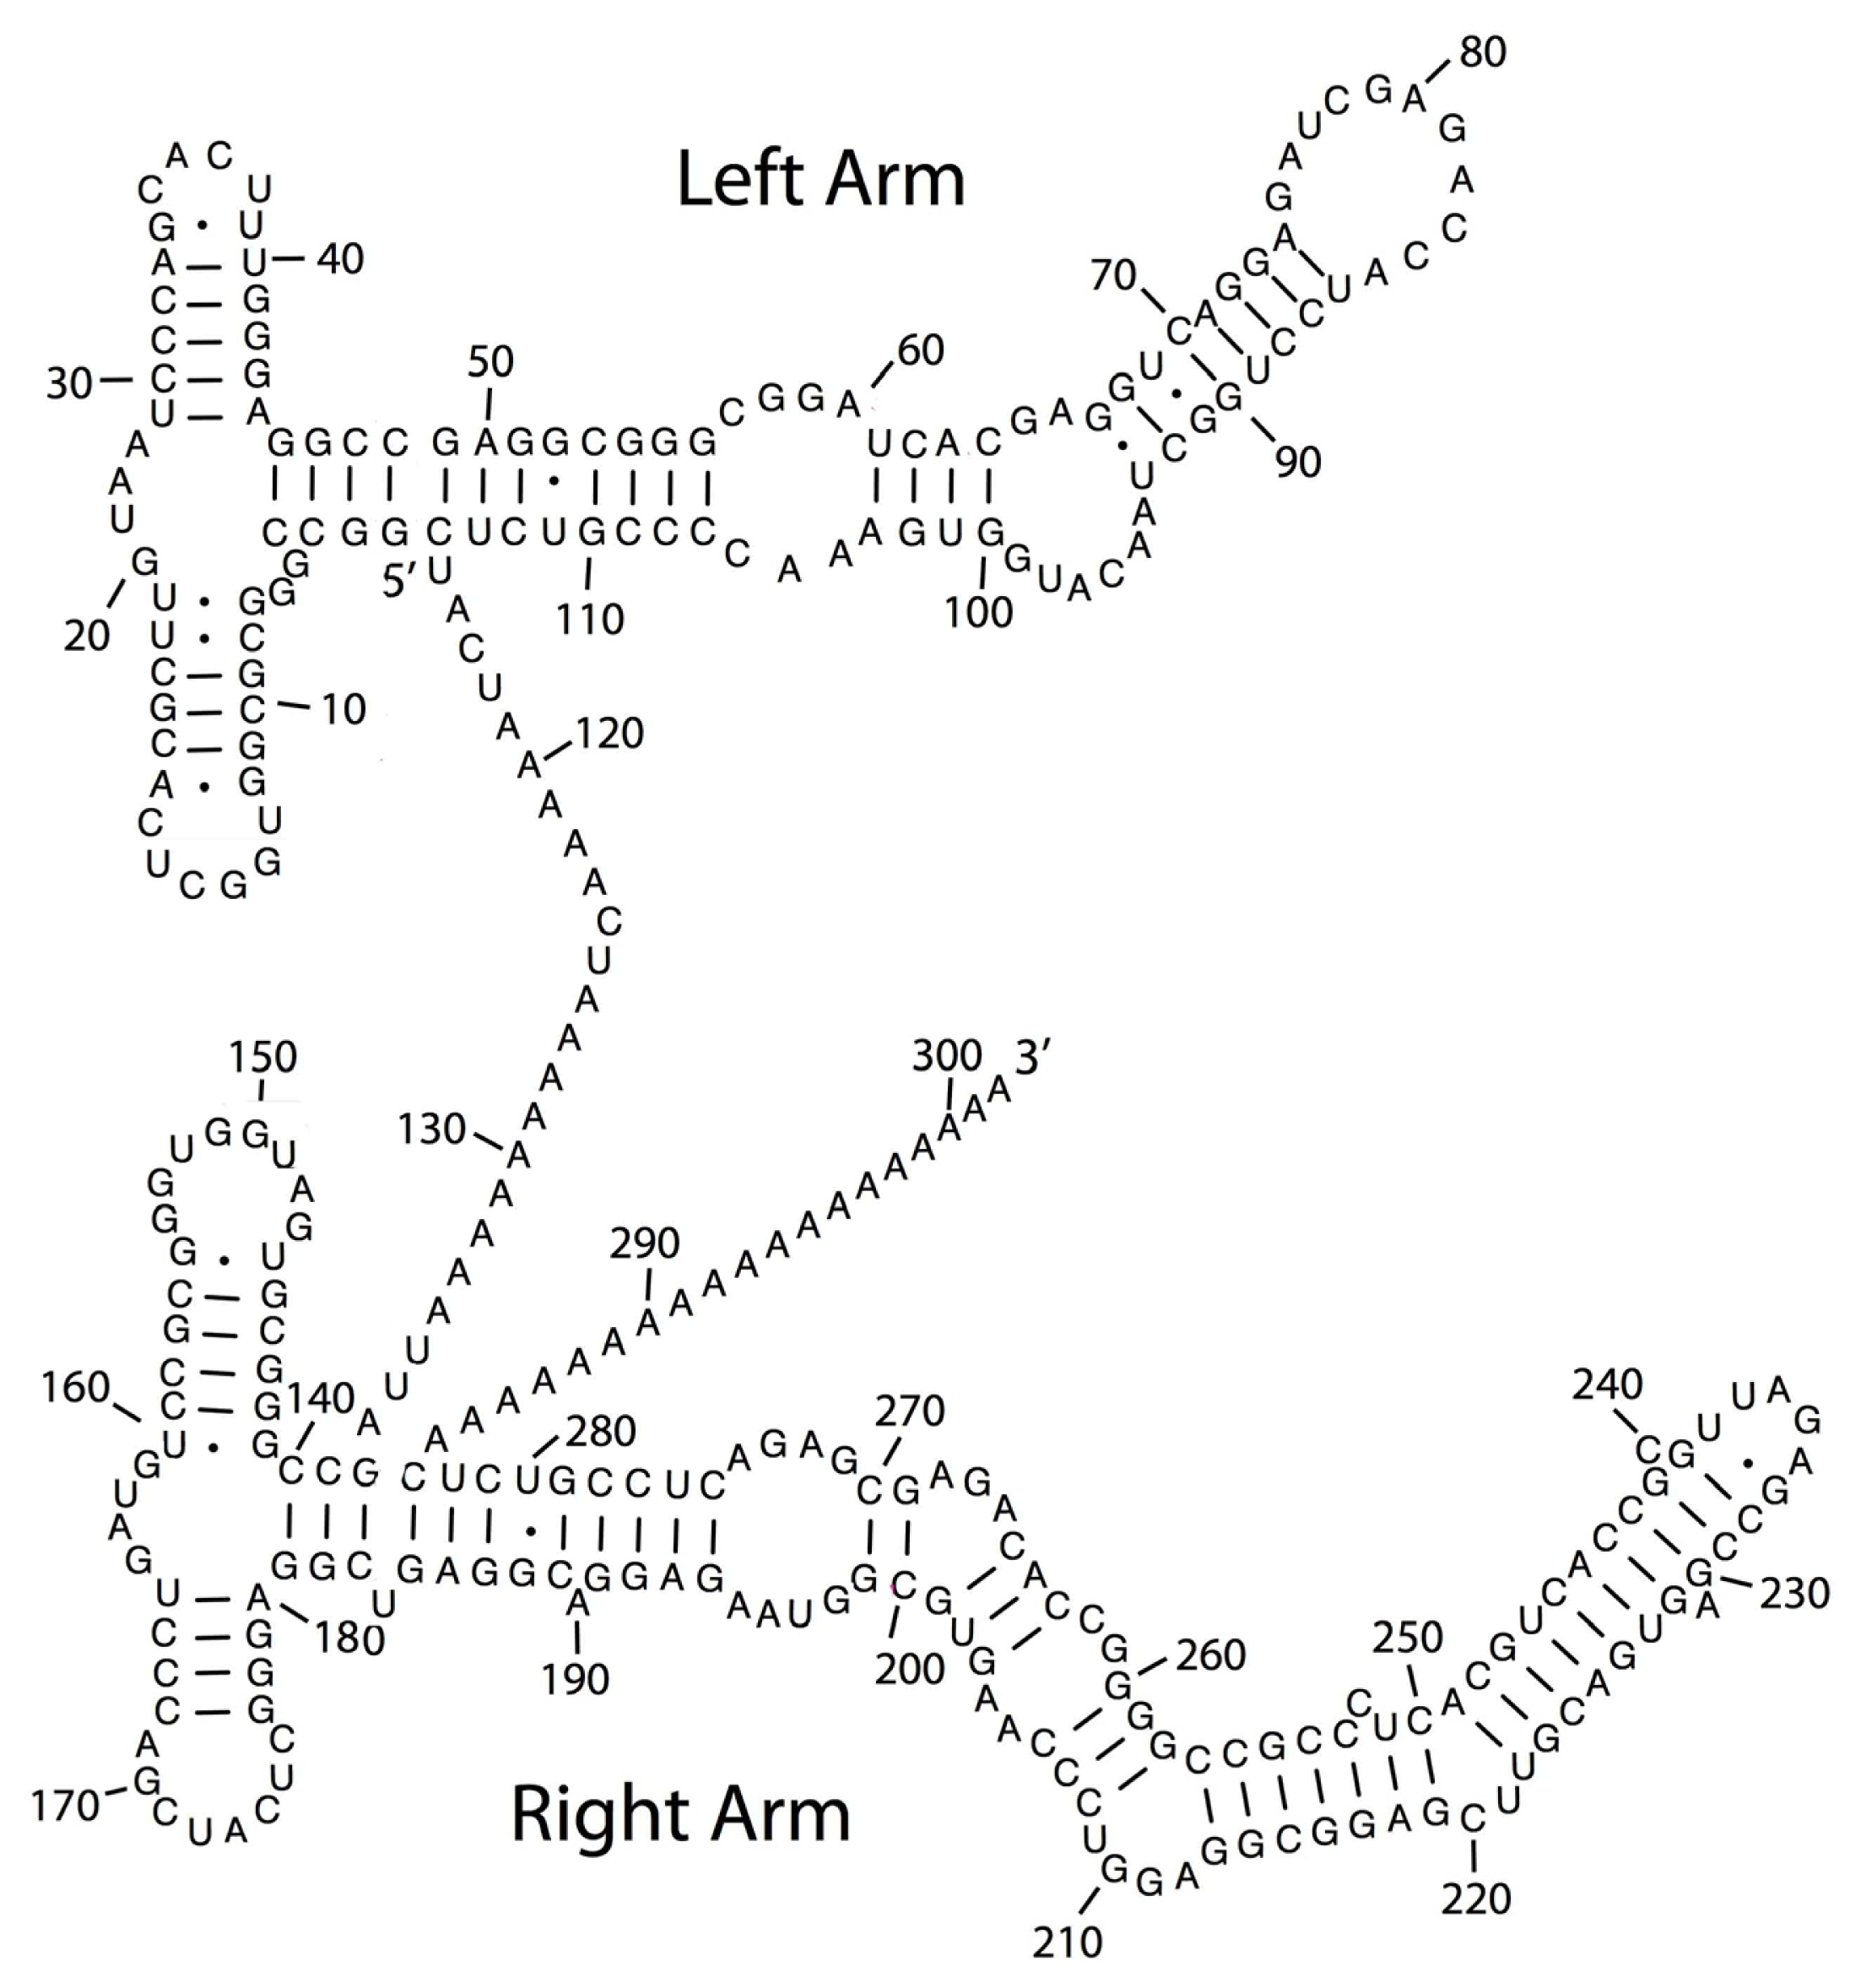

In [33]:
Image("http://www.mdpi.com/ijms/ijms-14-13307/article_deploy/html/images/ijms-14-13307f1.png")

We are almost done. To save the motifs for further processing we can save them in MEME format. For a sequence-structure data set the logo variable holds a tuple of Motif objects, the first tuple entry is the sequence motif and and the second the structure motif

In [15]:
utils.save_as_meme([logo[0] for logo in logos], output_folder+"motifs_seq.meme")
utils.save_as_meme([logo[1] for logo in logos], output_folder+"motifs_struct.meme")

We can do one more thing with our maximum activations from earlier and that is a hierarchical clustering of both sequences and kernels. In an ideal world the clustering will show you co-occurring motifs. In practice, you will often see that the network learns strong motifs multiple times and these will of course be close to each other in the cluster matrix. Neural networks are notoriously hard to interpret and require detours to get information. Nevertheless, the clustering gives a rough guide on where to start looking.

/home/budach/python/lib/python3.5/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))
/home/budach/python/lib/python3.5/site-packages/matplotlib/axes/_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0
  'bottom=%s, top=%s') % (bottom, top))


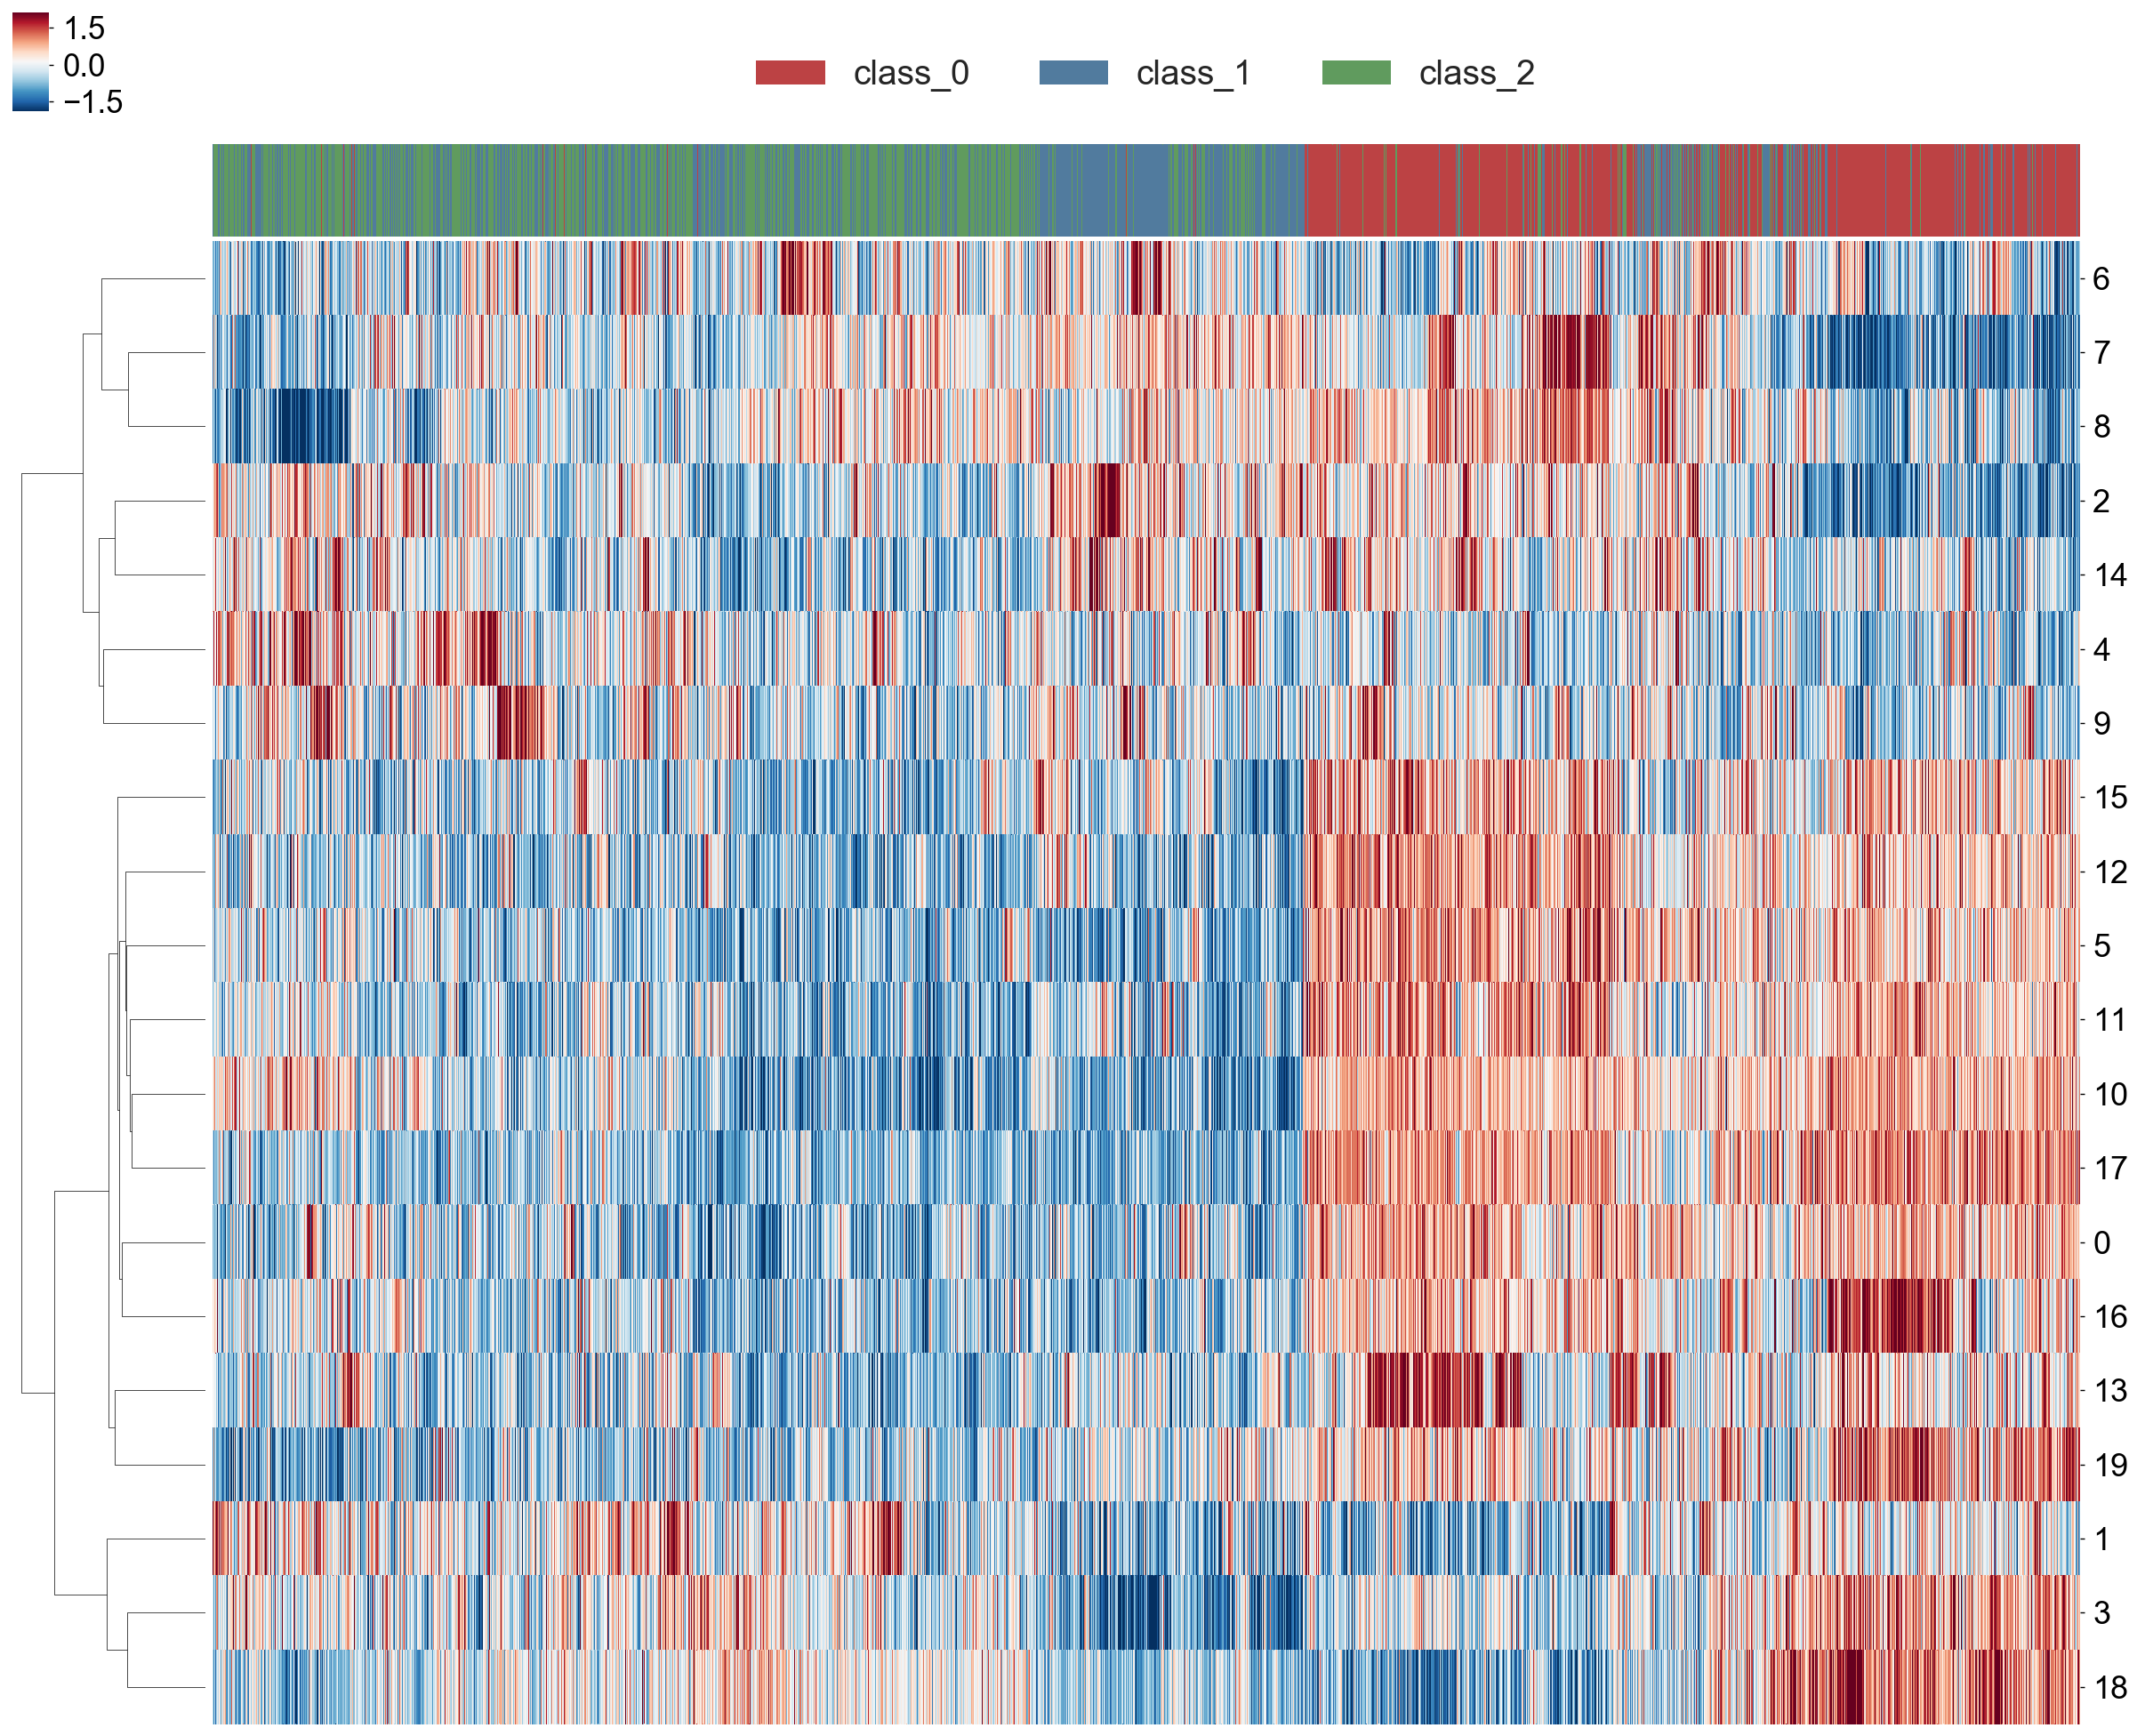

In [16]:
model.plot_clustering(activations, output_folder+"clustering.png")
Image(output_folder+"clustering.png")

And that is all about the main functionality of the network. Have a look at the API documentation to learn more about unmentioned parameters of some functions. Also have a look at the second tutorial if you want to learn more about visualizations beyond the first network layer.

In [17]:
utils.save_data(data, output_folder+"data.pkl")
utils.save_model(model, output_folder+"model.pkl")